# Wavenet

Here we build a wavenet model (a generative tts model from deepmind: https://arxiv.org/abs/1609.03499), again for the next_char modelling task.

The current limitations with the bengio model is we are directly squishing in k embeddings into the context and passing it through a single layer.
Especially as we scale the embeddings, we'll see that we're squashing too much information.

The wavenet model is a deeper network that allows processes the context over a longer period of time.
Additionally, it is a 'convolutional' approach basically. It allows us to process x contexts together (like a sliding window over samples), which is more efficient than processing one-by-one.

This will eventually lead into the transformer architecture (k blocks * (attention + feed-forward)) which ensures the model spends time reading the context and processing it.

In [604]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
g = torch.Generator().manual_seed(2147483647)

In [605]:
# Load the dataset
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

print(f"Count: {len(words)}, sample: {words[:5]}...")

Count: 32033, sample: ['emma', 'olivia', 'ava', 'isabella', 'sophia']...


In [606]:
# Get the dictionary of characters & converters
vocab = sorted(list(set("".join(words))))
stoi = {c:i+1 for i,c in enumerate(vocab)}
stoi['.'] = 0
# print(stoi)

itos = {i:c for c,i in stoi.items()}
# print(itos)

In [607]:
block_size = 8

In [608]:
# Process the dataset & split into train/valid/test datasets

x, y = [], []

context = [0] * block_size
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch in chs:
        x.append(context)
        ix = stoi[ch]
        y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(x)
Y = torch.tensor(y)

print(X[:4])
print(Y[:4])

# Split into train/valid/test
train_split = int(X.shape[0] * 0.8)
valid_split = int(X.shape[0] * 0.9)

X_train = X[:train_split]
Y_train = Y[:train_split]

X_valid = X[train_split:valid_split]
Y_valid = Y[train_split:valid_split]

X_test = X[valid_split:]
Y_test = Y[valid_split:]

#Check the ratio
total = X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]
print(f"Train: {X_train.shape[0]/total*100:.2f}% | Valid: {X_valid.shape[0]/total*100:.2f}% | Test: {X_test.shape[0]/total*100:.2f}%")

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  5, 13]])
tensor([ 0,  5, 13, 13])
Train: 80.00% | Valid: 10.00% | Test: 10.00%


In [609]:
# PyTorch layers implemented from scratch :)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.rand((fan_in, fan_out), generator=g) / fan_in ** 0.5 #Kaiman init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + [self.bias] if self.bias is not None else []

class BatchNorm:
    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# Let's define an embedding layer. As input: torch.tensor(block_size), as output: n_embed
class Embedding:
    def __init__(self, fan_in, fan_out):
        self.embed_size = fan_out
        self.embeddings = torch.randn((fan_in, fan_out), generator=g)

    def __call__(self, x):
        #TODO: [0,0,5] -> [Pluck out 0,0,5 from the embedding table and return view of merged [00, 00, 05]]
        self.out = self.embeddings[x]
        return self.out

    def parameters(self):
        return [self.embeddings]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# Let's create our own Sequential layer now:

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [610]:
# Let's use PyTorch! Initialize Linear, BatchNorm, TanH layers & parameters

# Parameters
max_steps = 200000
batch_size = 32
n_embed = 10
n_hidden = 200

model = Sequential([
    Embedding(len(stoi), n_embed),
    FlattenConsecutive(2), Linear(2 * n_embed, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, len(stoi))
])

with torch.no_grad():
    # Make the layer guesses less confident to start from a lower loss
    model.layers[-1].weight *= 0.1

    #Apply gain to other layers
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = model.parameters()

for p in parameters:
    p.requires_grad = True

# Number of parameters
print(f"Parameters: {sum([p.nelement() for p in parameters])}")

Parameters: 6897


In [611]:
#Debugging/Logging
losses = []

In [612]:
# Let's implement the training now
for i in range(max_steps):
    ix = torch.randint(X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None #Reset all grads

    loss.backward()

    # Optimizer step
    lr = 0.1 if i < (max_steps / 2) else 0.01 # learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

    losses.append(loss.item())
    if i % 1000 == 0:
        print(f"epoch: {i} | loss: {loss.item():.4f}")

epoch: 0 | loss: 3.3008
epoch: 1000 | loss: 2.9895
epoch: 2000 | loss: 2.5735
epoch: 3000 | loss: 2.3649
epoch: 4000 | loss: 2.5406
epoch: 5000 | loss: 2.5639
epoch: 6000 | loss: 2.4455
epoch: 7000 | loss: 2.4955
epoch: 8000 | loss: 2.4887
epoch: 9000 | loss: 2.7833
epoch: 10000 | loss: 2.3141
epoch: 11000 | loss: 2.0840
epoch: 12000 | loss: 2.6188
epoch: 13000 | loss: 2.2125
epoch: 14000 | loss: 2.1937
epoch: 15000 | loss: 2.3127
epoch: 16000 | loss: 2.8274
epoch: 17000 | loss: 2.2567
epoch: 18000 | loss: 2.3219
epoch: 19000 | loss: 2.4644
epoch: 20000 | loss: 2.6537
epoch: 21000 | loss: 2.0887
epoch: 22000 | loss: 2.0066
epoch: 23000 | loss: 2.3336
epoch: 24000 | loss: 2.3438
epoch: 25000 | loss: 2.3573
epoch: 26000 | loss: 2.7331
epoch: 27000 | loss: 2.3937
epoch: 28000 | loss: 2.1324
epoch: 29000 | loss: 2.2762
epoch: 30000 | loss: 2.3675
epoch: 31000 | loss: 3.1084
epoch: 32000 | loss: 2.6027
epoch: 33000 | loss: 2.3370
epoch: 34000 | loss: 2.0810
epoch: 35000 | loss: 2.4729
epoch

In [613]:
#Debug
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 200)
BatchNorm : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


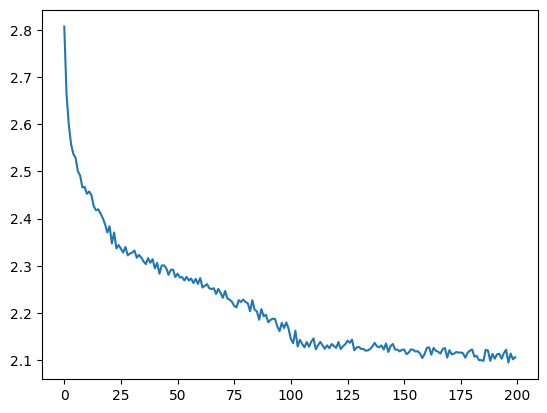

In [614]:
# Since we're using batches in training, the loss is unstable. We can average it over multiple steps instead
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [615]:
#Put the layers into eval mode (BatchNorm otherwise will continue updating mean/var)
for layer in model.layers:
    layer.training = False

In [616]:
# Get the training loss and validation loss to check if overfit/underfit (turn off training mode for the layers!)
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'valid': (X_valid, Y_valid),
        'test': (X_test, Y_test)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())

split_loss('train')
split_loss('valid')

train 2.078113317489624
valid 2.209001302719116


In [617]:
# TODO
# Plot the histograms of the pre-activation/post-activations to see if pre-activation is roughly gaussian and post-activation is barely saturated

# Plot the gradients between layers (ensure it's not exploding/vanishing)

# Plot the ratio of grad to data, ensure the updates are not crazy high (otherwise will need to scale)

In [618]:
# Sampling from the model
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        # print(logits)
        
        #Conditional probability distribution output
        probs = F.softmax(logits, dim=1)
        # print(probs)

        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1: ] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))
        

abteyyn.
dhav.
aogxin.
seaxril.
paoama.
uaol.
uaibiahea.
ioe.
oykevi.
ajy.
vrotaahe.
aly.
ioasyy.
diina.
oaapna.
eao.
aiikhcel.
aewmya.
oiiaaa.
rnnt.
